# Linear regression example

Data was taken from: https://www.kaggle.com/mirichoi0218/insurance

In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from torch.utils.data import TensorDataset, DataLoader
import time

In [2]:
#Get data from csv file
data = pd.read_csv("LinearExample/insurance.csv") 
# Preview the first 5 lines of the loaded data 
data.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


### Check bmi distribution

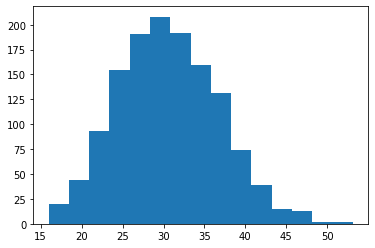

In [4]:
dataNp = data.to_numpy()
bmi = dataNp[:,2]
bmi = bmi.astype('float64')

plt.hist(bmi, bins=15)
plt.show()

### Check charges distribution

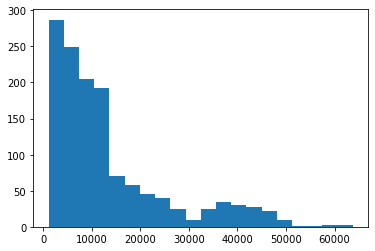

In [5]:
dataNp = data.to_numpy()

age = dataNp[:, 0]
age = age.astype('float64')
sex = dataNp[:, 1]
children = dataNp[:, 3]
charges = dataNp[:, 6]
charges = charges.astype('float64')


plt.hist(charges, bins=20)
plt.show()

### Checking relationship between age and charges

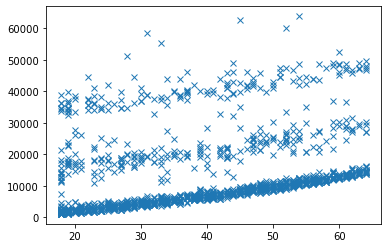

In [6]:
plt.plot(age, charges, 'x');

Checking plot, seems that there is a linear relation between these variables. It's very spreaded though.

Let's try to find a linear equation that fits this data just for fun.

### Train the model with pytorch

In [7]:
from sklearn.model_selection import train_test_split
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

In [37]:
#Get normalize values before spliting sets
ageNorm = np.linalg.norm(age)

#divide train and test dataset
X_train, X_test, y_train, y_test = train_test_split(age, charges, train_size=0.65,test_size=0.35)

#Get data sample sizes
trainDataSize = X_train.size
testDataSize = y_test.size

#normalize data
X_train =  X_train / ageNorm
X_test =  X_test / ageNorm

### Plot after normalization

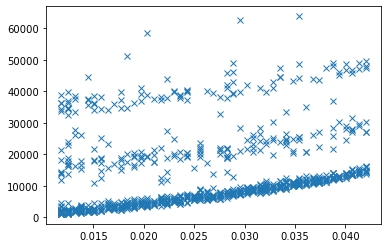

In [38]:
plt.plot(X_train, y_train, 'x');

### Use sklearn to train model and then plot calculated function and train data together

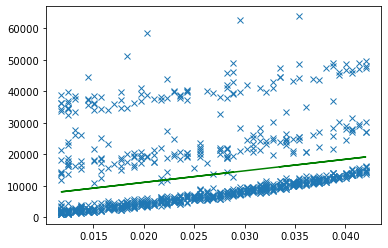

B0: [3805.15610746], B1: [365606.99355427]


In [44]:
from sklearn.linear_model import LinearRegression
linr = LinearRegression()
linr.fit(X_train.reshape(-1,1), y_train.reshape(-1,1))

beta0 = linr.intercept_
beta1 = linr.coef_[0]

yplot = X_train * beta1 + beta0

plt.plot(X_train, y_train, 'x');
plt.plot(X_train, yplot, 'g')
plt.show()

print(f'B0: {beta0}, B1: {beta1}')

### Use pytorch to train model

In [47]:
n_epochs = 90
batch_size_train = testDataSize
batch_size_test = testDataSize
learning_rate = 0.01
momentum = 0.5
log_interval = 10

# transform to torch tensor
tensor_train_x = torch.Tensor(X_train.reshape(-1, 1))
tensor_train_y = torch.Tensor(y_train.reshape(-1, 1))

# create your datset
train_data = TensorDataset(tensor_train_x, tensor_train_y)

#Create loader using data
train_loader = torch.utils.data.DataLoader(
    train_data,
    batch_size=batch_size_train,
    shuffle=True)

# transform to torch tensor
tensor_test_x = torch.Tensor(X_test.reshape(-1, 1))
tensor_test_y = torch.Tensor(y_test.reshape(-1, 1))

# create your datset
test_data = TensorDataset(tensor_test_x, tensor_test_y)

#Create loader using data
test_loader = torch.utils.data.DataLoader(
    test_data,
    batch_size=batch_size_test,
    shuffle=True)

In [48]:
class LayerLinearRegression(nn.Module):
    def __init__(self):
        super().__init__()
        # Instead of our custom parameters, we use a Linear layer with single input and single output
        self.linear = nn.Linear(1, 1)
                
    def forward(self, x):
        # Now it only takes a call to the layer to make predictions
        return self.linear(x)
    
#Network model
network = LayerLinearRegression()

#Configure loss function
LossFunction = nn.MSELoss(reduction='mean')

#Stochastic gradient decent
optimizer = optim.SGD(network.parameters(), lr=learning_rate,
                      momentum=momentum)

In [49]:
train_losses = []
train_counter = []
test_losses = []
test_counter = [i*len(train_loader.dataset) for i in range(n_epochs + 1)]

In [50]:
def train(epoch):
  #Configure network for training
  network.train()
  for batch_idx, (data, target) in enumerate(train_loader):
    
    #set parameters gradients to 0
    optimizer.zero_grad()
    
    #runs model with data and returns result in output
    #here data contains a 64 * 1 * 28 * 28 tensor, 64 is batch size
    output = network(data)
    
    #Use negative log likelihood loss.
    loss = LossFunction(output, target)
    
    #with this gradients are calculated
    loss.backward()
    
    #update gradients
    optimizer.step()
    
    #Display iteration statistics
    if batch_idx % log_interval == 0:
      print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
        epoch, batch_idx * len(data), len(train_loader.dataset),
        100. * batch_idx / len(train_loader), loss.item()))
      train_losses.append(loss.item())
      train_counter.append(
        (batch_idx*64) + ((epoch-1)*len(train_loader.dataset)))
      torch.save(network.state_dict(), 'results/model.pth')
      torch.save(optimizer.state_dict(), 'results/optimizer.pth')

In [51]:
def test():
  #Sets the module in evaluation mode
  network.eval()
  test_loss = 0
  correct = 0
    
  #dont update dynamic computation graph
  with torch.no_grad():
    #for every example in test
    for data, target in test_loader:
      #evaluate the model
      output = network(data)
        
      #acumulate the loss
      test_loss += LossFunction(output, target).item()
      
      pred = output.data.max(1, keepdim=True)[1]
      correct += pred.eq(target.data.view_as(pred)).sum()
  test_loss /= len(test_loader.dataset)
  test_losses.append(test_loss)
  print('\nTest set: Avg. loss: {:.4f}, Accuracy: {}/{} ({:.0f}%)\n'.format(
    test_loss, correct, len(test_loader.dataset),
    100. * correct / len(test_loader.dataset)))

In [53]:

#test
#n_epochs = 1

#Check accuaracy before training
test()
tic = time.perf_counter()

for epoch in range(1, n_epochs + 1):
  train(epoch)
  test()
    
toc = time.perf_counter()

print(f"Time elapsed: {toc - tic:0.4f} seconds")


Test set: Avg. loss: 326718.9765, Accuracy: 0/469 (0%)

Train Epoch: 1 [0/869 (0%)]	Loss: 147280880.000000

Test set: Avg. loss: 326711.9488, Accuracy: 0/469 (0%)

Train Epoch: 2 [0/869 (0%)]	Loss: 151068912.000000

Test set: Avg. loss: 326714.1663, Accuracy: 0/469 (0%)

Train Epoch: 3 [0/869 (0%)]	Loss: 141793680.000000

Test set: Avg. loss: 326715.3262, Accuracy: 0/469 (0%)

Train Epoch: 4 [0/869 (0%)]	Loss: 130750768.000000

Test set: Avg. loss: 326720.1365, Accuracy: 0/469 (0%)

Train Epoch: 5 [0/869 (0%)]	Loss: 145983536.000000

Test set: Avg. loss: 326713.4499, Accuracy: 0/469 (0%)

Train Epoch: 6 [0/869 (0%)]	Loss: 156990368.000000

Test set: Avg. loss: 326709.8678, Accuracy: 0/469 (0%)

Train Epoch: 7 [0/869 (0%)]	Loss: 153306528.000000

Test set: Avg. loss: 326712.8699, Accuracy: 0/469 (0%)

Train Epoch: 8 [0/869 (0%)]	Loss: 131407280.000000

Test set: Avg. loss: 326718.6695, Accuracy: 0/469 (0%)

Train Epoch: 9 [0/869 (0%)]	Loss: 133061280.000000

Test set: Avg. loss: 326711

Train Epoch: 76 [0/869 (0%)]	Loss: 133666360.000000

Test set: Avg. loss: 326678.3795, Accuracy: 0/469 (0%)

Train Epoch: 77 [0/869 (0%)]	Loss: 157647552.000000

Test set: Avg. loss: 326673.8763, Accuracy: 0/469 (0%)

Train Epoch: 78 [0/869 (0%)]	Loss: 131389016.000000

Test set: Avg. loss: 326679.1983, Accuracy: 0/469 (0%)

Train Epoch: 79 [0/869 (0%)]	Loss: 156227168.000000

Test set: Avg. loss: 326677.2196, Accuracy: 0/469 (0%)

Train Epoch: 80 [0/869 (0%)]	Loss: 132160080.000000

Test set: Avg. loss: 326682.0299, Accuracy: 0/469 (0%)

Train Epoch: 81 [0/869 (0%)]	Loss: 151099920.000000

Test set: Avg. loss: 326676.8443, Accuracy: 0/469 (0%)

Train Epoch: 82 [0/869 (0%)]	Loss: 142534208.000000

Test set: Avg. loss: 326680.1876, Accuracy: 0/469 (0%)

Train Epoch: 83 [0/869 (0%)]	Loss: 146971872.000000

Test set: Avg. loss: 326679.5394, Accuracy: 0/469 (0%)

Train Epoch: 84 [0/869 (0%)]	Loss: 148721824.000000

Test set: Avg. loss: 326679.2324, Accuracy: 0/469 (0%)

Train Epoch: 85 [0/

ModuleAttributeError: 'LayerLinearRegression' object has no attribute 'weight'

### Plot training result with pytorch

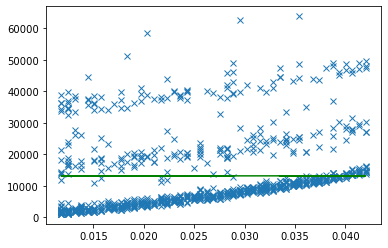

B0: [13160.917], B1: [[775.93256]]


In [70]:
beta0 = network.linear.bias.detach().numpy()
beta1 = network.linear.weight.detach().numpy()

yplot = X_train * beta1 + beta0
plt.plot(X_train, y_train, 'x');
plt.plot(X_train, yplot.reshape(-1, 1), 'g')
plt.show()

print(f'B0: {beta0}, B1: {beta1}')

# References

https://stackoverflow.com/questions/44429199/how-to-load-a-list-of-numpy-arrays-to-pytorch-dataset-loader
https://towardsdatascience.com/linear-regression-with-pytorch-eb6dedead817

# ToDo

Loss is high, but this might be because output values are high too.
Options to do
-Normalize outputs and train model again. Might no needed.
-Check ohter examples using nn.Linear, how they train their models